# Ejemplo 2.4: Principios de las Comunicaciones Digitales

Se tiene un problema de comunicación de un bit de información por un canal de fibra óptica. El bit transmitido es modelado por una variable aleatoria $ H \in {0,1}$, $ P_H(0) = 1/2 $. Si $ H = 1 $, se enciende un LED y su luz recorre la fibra óptica hasta un fotodetector. El fotodetector tiene como salida el número de photones $ Y \in \mathbb{N} $ que detecta. El problema radica en decidir si $ H = 0 $ (LED apagado) o $ H = 1 $ (led encendido). La decisión puede estar basada únicamente en la información a priori que se tiene sobre el modelo y la información de la observación actual $ Y = y $. Es imposible determinar $H$ a partir de $Y$ con certeza. Incluso si el LED está apagado, el fotodetector puede detectar algunos fotones provenientes de la luz ambiente, por ejemplo. Se puede asumir que $Y$ es representa una distribución de Poisson con parámetro $ \lambda $, que depende de si el LED está encendido o apagado. 


Se comienza importando los packetes necesarios:

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.figure_factory as ff
from scipy.stats import norm, invgamma
from collections import Counter

Para generar la distribución de Poisson, primero se deben definir los parámetros $ \lambda $ de cada una de ellas. A modo de ejemplo, se define:
$$
\lambda_0 = 2 \\
\lambda_1 = 5
$$

In [21]:
lambda_0 = 2
lambda_1 = 5

Ahora, se generan las variables aleatorias que responden a esas distribuciones y se las guarda en un DataFrame.

In [36]:
h0 = np.random.poisson(lambda_0, 10000)
h1 = np.random.poisson(lambda_1, 10000)
df = pd.DataFrame({'H0':h0, 'H1':h1})
df

,H0,H1
0,1,9
1,2,3
2,4,5
3,0,6
4,1,0
...,...,...
9995,2,11
9996,2,6
9997,4,8
9998,1,1


Se crean los histogramas para las variables generadas.

In [38]:
fig = ff.create_distplot([df[c] for c in df.columns], df.columns, curve_type="normal")
fig.update_layout(title='Histrogramas para variables aleatorias de Poisson')
fig.show()

Ahora se debe simular el comportamiento del canal mediante el uso de un generador de entradas y un análisis de la salida.

In [31]:
channelHypothesis = np.random.randint(0, 2, 10000)
channelOutput = []
for i in range(len(channelHypothesis)):
    if(channelHypothesis[i] > 0):
        channelOutput.append(np.random.poisson(lambda_1))
    else:
        channelOutput.append(np.random.poisson(lambda_0))

Ahora, como el criterio de decisión es:
$$
y\gt 1 \Rightarrow \hat{H}=1 \\ y\le 1 \Rightarrow \hat{H}=0
$$
Se debe discriminar en el nivel 1.

In [74]:
level = 1
detectedInput = []
for i in range(len(channelHypothesis)):
    if(channelOutput[i] > level):
        detectedInput.append(1)
    else:
        detectedInput.append(0)

El codigo anterior funciona como un saturador.

A continuación, es necesario obtener la probabilidad de error. Que está definida como la expectatica teórica de la tasa de error (Bit Error Rate) para un sistema determinado. Esa probabilidad de error se calcula a continuación.

In [34]:
ep = (sum(abs(channelHypothesis - np.array(detectedInput))))/10000
print('Probabilidad de error: ', ep)

Probabilidad de error:  0.4993


Ahora, para el canal de fibra óptica, teniendo a $y$ como la cantidad de fotones a la salida del fotodetector, tal como se definió antes. La media y la varianza están dadas por:
$$
\mu = E\{y\}=\sum_{y=0}yp(y)=\sum_{y=0}yp(y/h_0)p(h_0)+\sum_{y=0}yp(y/h_1)p(h_1)=\lambda_0 p(h_0)+\lambda_1p(h_1)$$
$$\sigma^2=E\{(y-\mu)^2\}=\lambda_0 p(h_0)+\lambda_1p(h_1)
$$
Se considera que el promedio de fotones recibido es una medida de la intensidad lumínica promedio $\rho$. Se grafica como varía la probabilidad de error a medida que aumenta $\rho$.
Para obtener las diferentes SNR (Signal to Noise Ratio) se deben obtener diferentes $\lambda_1$.

Ahora, con esos diferentes $ \lambda_1 $ y para distintos $ \lambda_0 $ se obtienen los siguientes diagramas del Bit Error Rate.

[0.3688 0.2072 0.076  0.0227 0.0008]


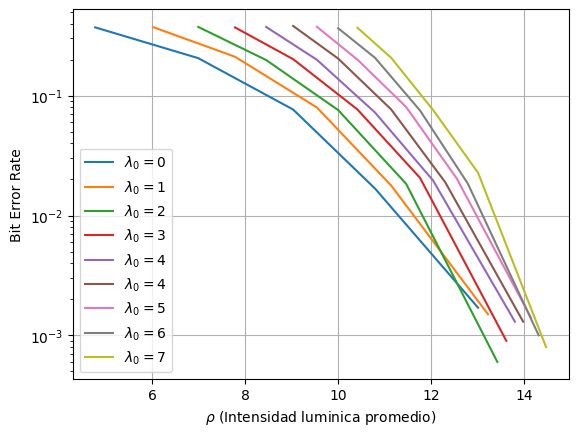

In [67]:
lambda1 = np.array([3,5,8,12,20])
intensity_dB = 10*np.log10(lambda_0 + lambda1)
bitErrorRate = np.array([])
lambda0 = [0,1,2,3,4,5,6,7,8]
for i in lambda0:
    intensity_dB = 10*np.log10(i + lambda1)
    bitErrorRate = np.array([])
    for lambda_i in lambda1:
        y = [np.random.poisson(lambda_i) if channelHypothesis[i]>0 else np.random.poisson(lambda_0) for i in range(10000)]
        level =  (lambda_i-lambda_0)/np.log(lambda_i/lambda_0)
        detectedHypothesis = [1 if y[i]>level else 0 for i in range(10000)]
        bitErrorRate = np.append(bitErrorRate, sum(abs(np.array(detectedHypothesis) - channelHypothesis))/10000)
    plt.semilogy(intensity_dB, bitErrorRate)
print(bitErrorRate)

plt.xlabel(r'$\rho$ (Intensidad luminica promedio)')
plt.ylabel('Bit Error Rate')
plt.legend(['$\lambda_0 = 0$','$\lambda_0 = 1$','$\lambda_0 = 2$','$\lambda_0 = 3$','$\lambda_0 = 4$','$\lambda_0 = 4$','$\lambda_0 = 5$','$\lambda_0 = 6$','$\lambda_0 = 7$','$\lambda_0 = 8$'])
plt.grid()